<a href="https://colab.research.google.com/github/Poltoratskiy/test/blob/main/movies_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pyspark > /dev/null
! pip install catboost > /dev/null
! pip install nltk > /dev/null
! pip install xgboost > /dev/null
! pip install spacy  > /dev/null

In [ ]:
'''
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

In [59]:
import gc
import nltk
import spacy
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from nltk.stem import PorterStemmer
from pyspark.sql import SparkSession
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
from wordcloud import WordCloud, STOPWORDS
from catboost import Pool, CatBoostClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, roc_auc_score

In [3]:
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
PROJECT_HOME = '/content/drive/My Drive/Colab Notebooks/movies_review'

In [5]:
target_param = 'is_positive'

In [6]:
scaler = StandardScaler()

In [7]:
def df_num(df):
    return df.select_dtypes(include = ['float64', 'int64'])

In [8]:
def get_size_df(df):
  def b_to_mb(value_in_bytes) -> float:
      """Bytes to megabytes"""
      return value_in_bytes / float(1 << 20)
  df_size = df.memory_usage(index=False, deep=True).sum()
  print('df shape {}'.format(df.shape))
  print('df has size {} bytes ({:,.3f} MB)'.format(df_size, b_to_mb(df_size)))

In [6]:
spark = SparkSession \
    .builder \
    .appName("classification") \
    .getOrCreate()

In [7]:
schema = StructType([
    StructField('text', StringType(), nullable=False),
])

In [ ]:
train_df_neg = spark.read.csv(f'{PROJECT_HOME}/data/train/neg.csv', schema=schema).toPandas()
train_df_pos = spark.read.csv(f'{PROJECT_HOME}/data/train/pos.csv', schema=schema).toPandas()
test_df_neg = spark.read.csv(f'{PROJECT_HOME}/data/test/neg.csv', schema=schema).toPandas()
test_df_pos = spark.read.csv(f'{PROJECT_HOME}/data/test/pos.csv', schema=schema).toPandas()

for df in [train_df_neg, test_df_neg]:
  df[target_param] = 0

for df in [train_df_pos, test_df_pos]:
  df[target_param] = 1

df = pd.concat([train_df_neg, test_df_neg, train_df_pos, test_df_pos])

## EDA & Features

In [ ]:
raw_features = list()

In [30]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

**Соберем фичи для до того как начнем чистить данные, но не все, а те, на которые стоит посмотреть в изначальном виде, но в любом случае надо убрать html разметку, так как они никак не относятся к ревью.**

In [ ]:
def exclude_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:
df['text'] = df['text'].apply(lambda x: exclude_html(x))

*Функция для выполнения различных математических преобразований на текущими фичами с целью создать новые*

In [38]:
def do_math_magic(df, cols)->pd.DataFrame:
  for col in cols:
    df[f'sqrt_{col}'] = df[col].apply(np.sqrt)
    df[f'square_{col}'] = df[col].apply(np.square)
  return df

В тексте некоторые словосочетания или набор слов соединены через нижнее подчеркивание, стоит его подменить на пробел

In [ ]:
def contain_underscore(df):
  """Add new feature and replace underscore by space"""
  df['contain_underscore'] = df['text'].apply(lambda x: len([s for s in x if '_' in s]))
  df['text'] = df['text'].apply(lambda x: x.replace('_',' '))

raw_features.append(contain_underscore)

In [ ]:
def raw_review_len(df):
  df['raw_review_lenght']  = df['text'].str.len()

raw_features.append(raw_review_len)

In [ ]:
def digits_number(df):
  df['digits_number'] = df['text'].apply(lambda x: len([s for s in x.split(' ') if s.isdigit()]))

raw_features.append(digits_number)

In [ ]:
def contain_imdb(df):
  df['contain_imdb'] = df['text'].apply(lambda x: 'imdb' in x.lower())

raw_features.append(contain_imdb)

In [ ]:
def contain_spoiler(df):
  df['contain_spoiler'] = df['text'].apply(lambda x: 'spoiler' in x.lower())

raw_features.append(contain_spoiler)

In [ ]:
def contain_exclamation(df):
  df['contain_exclamation'] = df['text'].apply(lambda x: len([s for s in x if '!' in s]))

raw_features.append(contain_exclamation)

In [ ]:
def contain_question(df):
  df['contain_question'] = df['text'].apply(lambda x: len([s for s in x if '?' in s]))

raw_features.append(contain_question)

In [ ]:
def sentiment_scores(df):
  sid = SentimentIntensityAnalyzer()
  df['sentiment_scores'] = df['text'].apply(lambda x:  sid.polarity_scores(x))
  df['sentiment_neg'] = df['sentiment_scores'].apply(lambda x: x['neg'])
  df['sentiment_pos'] = df['sentiment_scores'].apply(lambda x: x['pos'])
  df['sentiment_neu'] = df['sentiment_scores'].apply(lambda x: x['neu'])
  df.drop(['sentiment_scores'], axis=1, inplace=True)


Проверка того, что окрас выполняет леммитизацию

In [ ]:
sid = SentimentIntensityAnalyzer()
sentence = 'Roger Dodger is one of the most compelling variations on this theme.'
lemm_sentence = " ".join([token.lemma_ for token in nlp(sentence) if str(token).isalpha()])
print(sentence, sid.polarity_scores(sentence))
print(lemm_sentence, sid.polarity_scores(lemm_sentence))

Roger Dodger is one of the most compelling variations on this theme. {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'compound': 0.2944}
Roger Dodger be one of the most compelling variation on this theme {'neg': 0.0, 'neu': 0.834, 'pos': 0.166, 'compound': 0.2944}


In [ ]:
for func in raw_features:
  func(df)

Посмотрим на корреляции

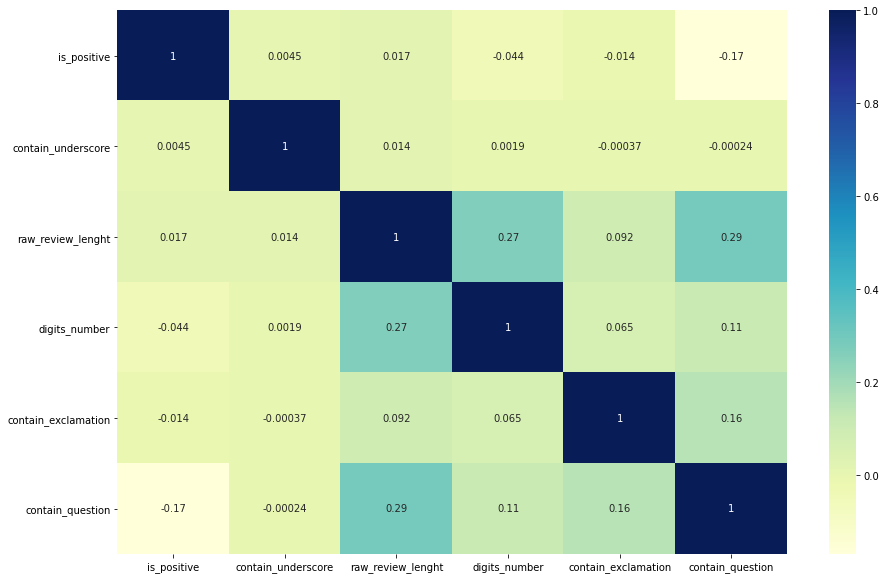

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_num(df).corr(), cmap='YlGnBu', annot=True);

Посмотрим на корреляцию Спирмана

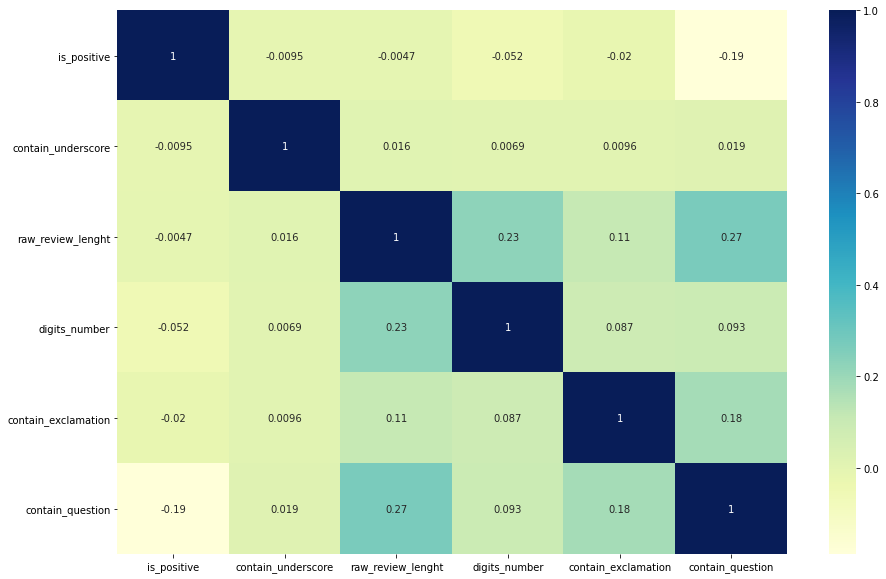

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_num(df).corr(method = 'spearman'), cmap='YlGnBu', annot=True);

Есть сильная корреляция с sentiment_neg и sentiment_pos


Посмотрим на график рассеивания, так как фич очень много, отберем только те,которые хорошо себя показали на корреляции (на самом деле посмотрел на все, но ничего полезного из большинства не извлек)

**Очистим текст от бесполезных слов и пунктуации**

In [31]:
stop = set(stopwords.words('english'))
punctuation = list(punctuation)
stop.update(punctuation)

Применим лемматизацию для приведения к простой форме и для дальнейшего анализа уже уникальных слов

In [ ]:
lemmer = nltk.stem.WordNetLemmatizer()

def lemmatize_sentence(sentence):
    token_words=word_tokenize(sentence)
    lem_sentence=[]
    for word in token_words:
      if str(word).strip().lower() not in stop and str(word).strip().isalpha():
        lem_sentence.append(lemmer.lemmatize(word))
        lem_sentence.append(" ")
    return "".join(lem_sentence)

df['text_lemmatized'] = df.text.apply(lemmatize_sentence)

In [ ]:
def spacy_lemmatize_sentence(sentence):
    token_words=nlp(sentence)
    lem_sentence=[token.lemma_ for token in token_words if not token.is_stop and str(token).isalpha()]
    return " ".join(lem_sentence)

df['text_lemmatized_spacy'] = df.text.apply(spacy_lemmatize_sentence)

*как делается лемматизация у spacy*

Смотрит на суффиксы и использует словарь  

https://github.com/explosion/spaCy/blob/master/spacy/lemmatizer.py#L14

In [ ]:
df[['text', 'text_lemmatized', 'text_lemmatized_spacy']].head()

## Почему nltk не преобразовал корректно?

In [35]:
lemmatizer = nltk.stem.WordNetLemmatizer()
word="web based technologies"
splits=word.split()
word_1=" ".join(lemmatizer.lemmatize(w, 'v') for w in splits)
print('verb: ', " ".join(lemmatizer.lemmatize(w, 'v') for w in splits))
print('noun: ', " ".join(lemmatizer.lemmatize(w, 'n') for w in splits))
print('none: ', " ".join(lemmatizer.lemmatize(w) for w in splits))

verb:  web base technologies
noun:  web based technology
none:  web based technology


NLTK ждет на вход тип слова, по умолчанию считает что пришло существительное, поэтому не всегда корректно обрабатывает

Нормализация spaCy кажется более корректной, буду использовать ее

In [ ]:
df['text_lemmatized'] = df['text_lemmatized_spacy']
df.drop(['text_lemmatized_spacy'], axis=1, inplace=True)

In [ ]:
sentiment_scores(df)

*Дампим версию данных*

In [9]:
#df.to_pickle(f'{PROJECT_HOME}/data/stage/stage_0.pkl')

In [30]:
df = pd.read_pickle(f'{PROJECT_HOME}/data/stage/stage_0.pkl')

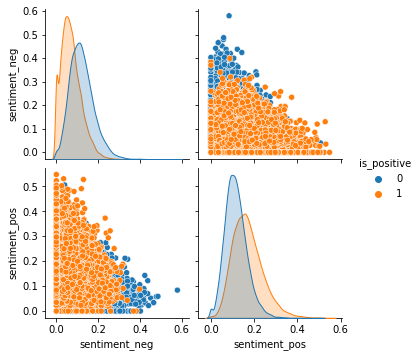

In [ ]:
sns.pairplot(df[['is_positive', 'sentiment_neg', 'sentiment_pos']], hue="is_positive");

Эмоциональная окраска предложений коррелирует с типом отзыва: у негативного отзыва в среднем окрас более негативный (капитан очевидность)

In [32]:
c = Counter(" ".join(df["text_lemmatized"]).split())

In [33]:
def count_most_frequency_words(d:Counter, percentage: int = 90):
  total_num = sum(c.values())
  result = 0
  acc_number = 0
  ordered_counter = d.most_common()
  while acc_number/total_num < percentage/100:
    val, num = ordered_counter.pop(0)
    acc_number += num
    result += 1
  return result

In [34]:
number = count_most_frequency_words(c, 80)
small_number = count_most_frequency_words(c, 75)

In [35]:
vec = TfidfVectorizer(stop_words='english', max_df=0.5, max_features=number)
vec_mini = TfidfVectorizer(stop_words='english', max_df=0.5, max_features=small_number)

Посмотреть распределение слов по случайности. 90% ограничение мб.  

Загуглить sparse TF-IDF  

In [36]:
_df = pd.DataFrame.sparse.from_spmatrix(vec.fit_transform(df['text_lemmatized']), columns = vec.get_feature_names())
vec_mini.fit(df['text_lemmatized']);

In [45]:
df_mini_columns = set(df.columns) | set(vec_mini.get_feature_names())

In [46]:
with open(f'{PROJECT_HOME}/data/stage/df_mini_columns.pkl', 'wb') as f:
  pickle.dump(list(df_mini_columns), f)

In [47]:
with open(f'{PROJECT_HOME}/data/stage/df_mini_columns.pkl', 'rb') as f:
  df_mini_columns = pickle.load(f)

In [48]:
df = pd.concat([df, _df], axis=1, join='inner')
del _df

Посмотрим на длину очищенного текста

In [20]:
df['review_lenght']  = df['text_lemmatized'].str.len()

Дампим версию данных

In [25]:
df.to_pickle(f'{PROJECT_HOME}/data/stage/stage_1.pkl')

In [49]:
df = pd.read_pickle(f'{PROJECT_HOME}/data/stage/stage_1.pkl')

Посмотрим на изменение в распределении длины ревью до и после очистки

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


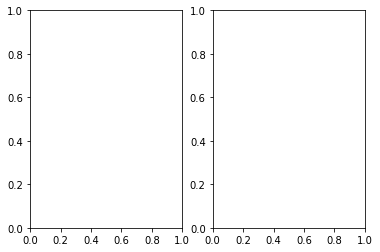

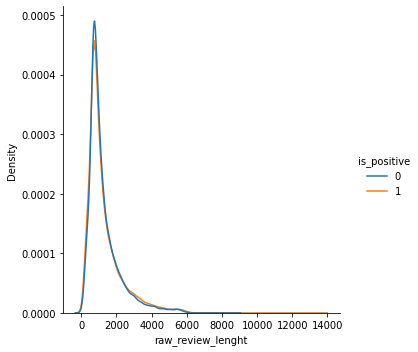

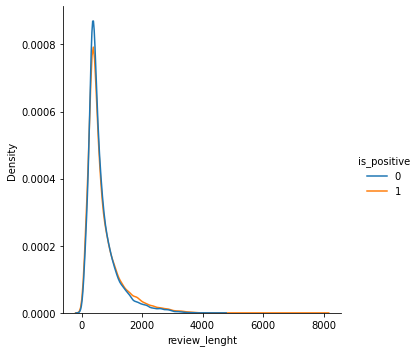

In [20]:
fig, ax = plt.subplots(1,2)
sns.displot(data=df, x='raw_review_lenght', hue='is_positive', kind='kde', ax=ax[0]);
sns.displot(data=df, x='review_lenght', hue='is_positive', kind='kde', ax=ax[1]);
fig.show();

Вид распределения не поменялся

Посмотрим на облако слов, может что-то даст

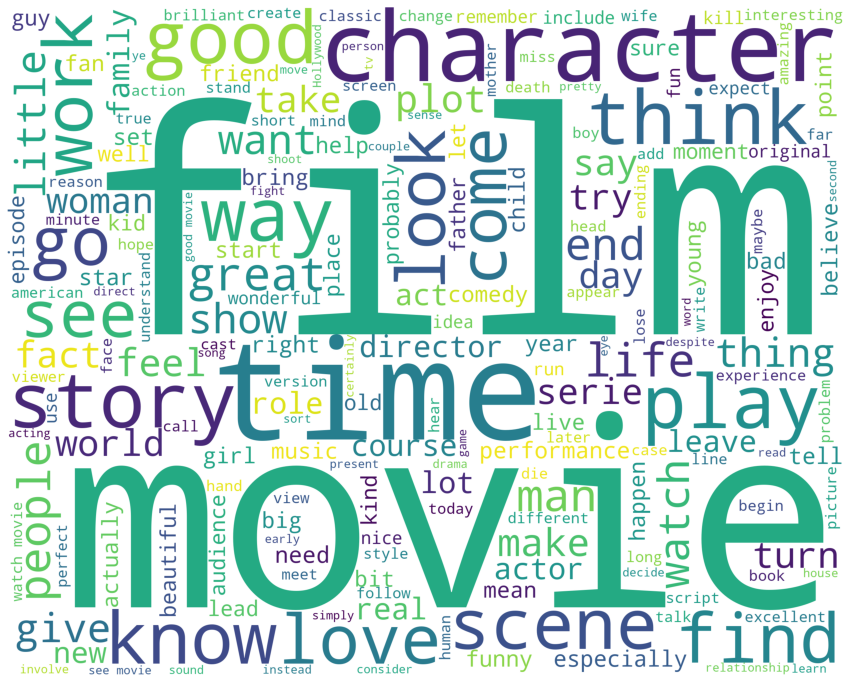

In [28]:
df_pos = df[df['is_positive']==1]['text_lemmatized']

wc_pos = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))

plt.figure(1,figsize=(15, 15))
plt.imshow(wc_pos)
plt.axis('off')
plt.show();

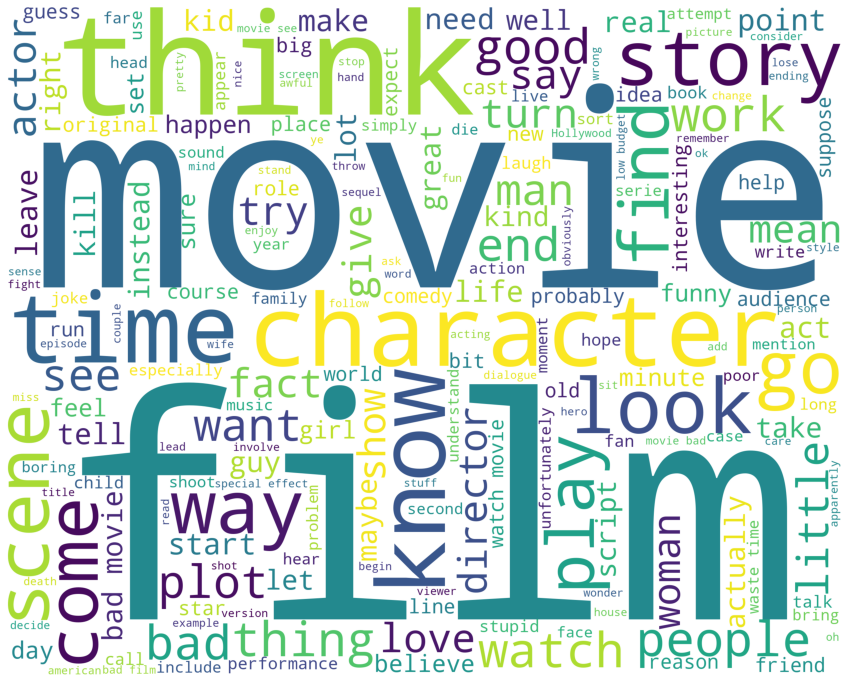

In [29]:
df_neg = df[df['is_positive']==0]['text_lemmatized']

wc_neg = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(15, 15))
plt.imshow(wc_neg)
plt.axis('off')
plt.show();

Выкинем общие распространенные и перестроим

In [30]:
excluded = set(sorted(wc_pos.words_, key=wc_pos.words_.get, reverse=True)[:10]) & set(sorted(wc_neg.words_, key=wc_neg.words_.get, reverse=True)[:10])
excluded

{'character', 'film', 'know', 'movie', 'story', 'think', 'time', 'way'}

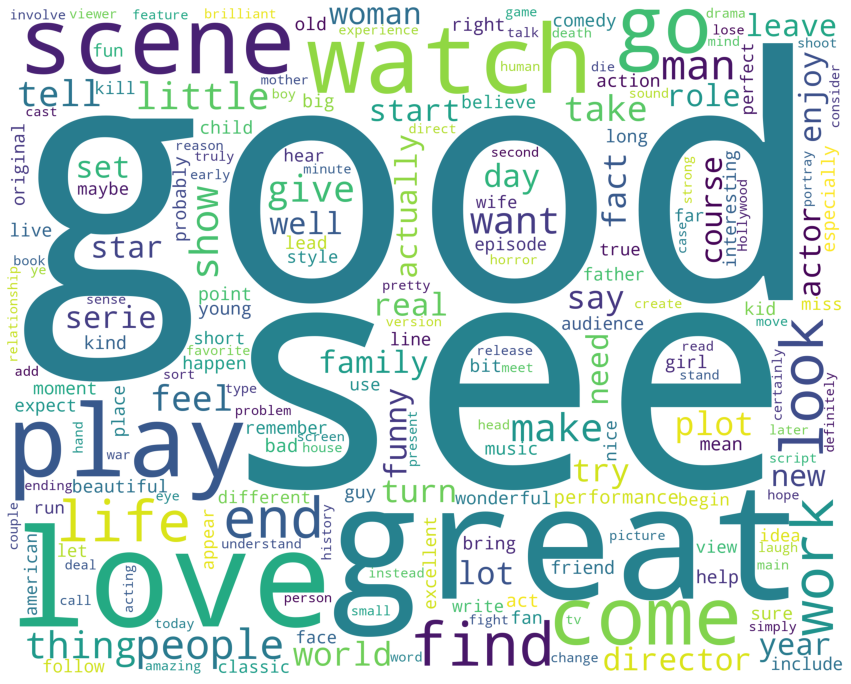

In [31]:
wc_pos = WordCloud(stopwords=STOPWORDS | excluded,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))
plt.figure(1,figsize=(15, 15))
plt.imshow(wc_pos)
plt.axis('off')
plt.show();

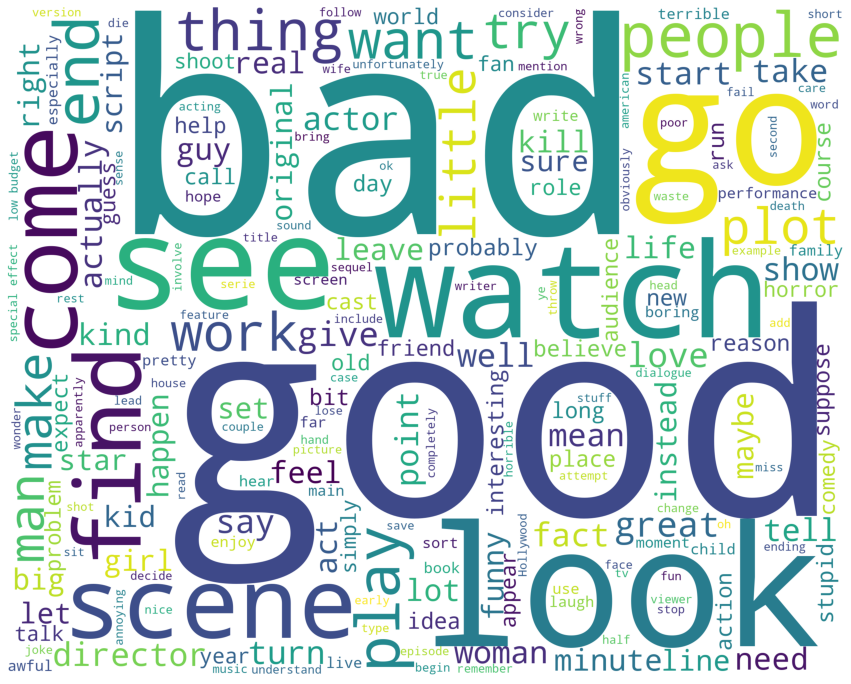

In [32]:
wc_neg = WordCloud(stopwords=STOPWORDS | excluded,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(15, 15))
plt.imshow(wc_neg)
plt.axis('off')
plt.show();

Каких-то особенно выделяющихся слов не обнаружено, слово great и bad можно вкинуть

In [33]:
top_pos = set(sorted(wc_pos.words_, key=wc_pos.words_.get, reverse=True)[:10])
top_neg = set(sorted(wc_neg.words_, key=wc_neg.words_.get, reverse=True)[:10])
positive_bagwords =  list(top_pos - top_neg)
negative_bagwords = list(top_neg - top_pos)

In [34]:
del df_neg
del df_pos
del wc_pos
del wc_neg
gc.collect()

In [35]:
df['contain_great'] = df['text_lemmatized'].apply(lambda x: len([s for s in x.split(' ') if s.lower() in positive_bagwords]))
df['contain_bad'] = df['text_lemmatized'].apply(lambda x: len([s for s in x.split(' ') if s.lower() in negative_bagwords]))

In [36]:
df['unique_word_count'] = df['text_lemmatized'].apply(lambda x:len(set(x.split(' '))))

## Посмотрим на распределение значений у фич, которые получили

<Figure size 1080x720 with 0 Axes>

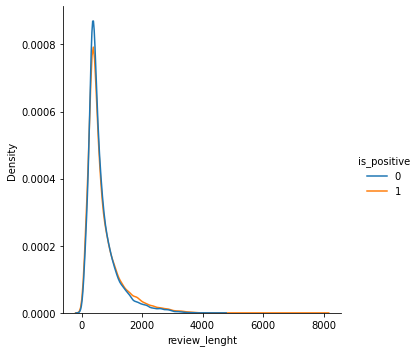

In [30]:
plt.figure(figsize=(15, 10))
sns.displot(data=df, x='review_lenght', hue='is_positive', kind='kde');

In [39]:
df = do_math_magic(df, ['raw_review_lenght', 'sentiment_neg', 'sentiment_pos', 'sentiment_neu', 'review_lenght', 'unique_word_count'])

In [32]:
df.head()

,text,is_positive,contain_underscore,raw_review_lenght,digits_number,contain_imdb,contain_spoiler,contain_exclamation,contain_question,text_lemmatized,sentiment_neg,sentiment_pos,sentiment_neu,aamir,aaron,ab,abandon,abbey,abbot,abbott,abc,abduct,abduction,ability,able,ably,aboard,abominable,abomination,abortion,abound,abraham,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absorb,...,yeti,yo,yokai,york,young,youngster,youth,youthful,youtube,yul,yup,yuppie,zach,zane,zany,zealand,zelah,zellweger,zero,zeta,zhang,zip,zizek,zodiac,zoe,zoey,zombi,zombie,zombies,zone,zoo,zoom,zorro,zu,zucco,zucker,review_lenght,contain_great,contain_bad,unique_word_count
0,Some have praised Atlantis: The Lost Empire ...,0,13,8681,0,False,True,5,3,praise Atlantis Lost Empire Disney adventure a...,0.115,0.083,0.802,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.021548,0.035937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.041474,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4583,2,6,439
1,Some have praised -Atlantis:-The Lost Empire- ...,0,0,8466,0,False,True,5,3,praise lose Disney adventure adult think think...,0.113,0.084,0.803,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.023559,0.039291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.045345,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4468,2,5,436
2,"*** Warning - this review contains ""plot spoil...",0,0,7665,1,True,True,6,5,warn review contain plot spoiler spoil movie b...,0.182,0.119,0.699,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,4127,4,19,366
3,This movie was recently released on DVD in the...,0,0,7551,1,False,False,15,5,movie recently release dvd finally get chance ...,0.159,0.065,0.777,0.0,0.0,0.0,0.028343,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.040306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.08562,0.553908,0.0,0.031531,0.0,0.000000,0.0,0.0,0.0,0.0,3972,0,10,398
4,"Raising Victor Vargas: A ReviewYou know, Raisi...",0,0,7310,0,False,False,0,6,raise Victor Vargas ReviewYou know raise Victo...,0.079,0.105,0.816,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.014744,0.019100,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.021388,0.0,0.0,0.0,0.0,4123,6,3,366


### Дампим версию данных

In [40]:
df.to_pickle(f'{PROJECT_HOME}/data/stage/stage_2.pkl')

In [50]:
df = pd.read_pickle(f'{PROJECT_HOME}/data/stage/stage_2.pkl')

In [51]:
df_mini = df[df_mini_columns]

### Models

In [53]:
def get_metrics(y_test, y_pred):
  print(confusion_matrix(y_test, y_pred))
  print('---'*10)
  print('ROC-AUC', roc_auc_score(y_test, y_pred))
  print('---'*10)
  print(classification_report(y_test, y_pred))

In [54]:
X_stnd = scaler.fit_transform(df[df.columns.difference([target_param, 'text', 'text_lemmatized'])])
y_stnd = df[target_param]
X_train, X_test, y_train, y_test = train_test_split(X_stnd, y_stnd, test_size=0.20)

In [55]:
X_stnd_mini = scaler.fit_transform(df_mini[df_mini.columns.difference([target_param, 'text', 'text_lemmatized'])])
X_train_mini, X_test_mini, y_train, y_test = train_test_split(X_stnd_mini, y_stnd, test_siznaive_model = GaussianNB()
naive_model.fit(X_train_mini, y_train)
y_pred = naive_model.predict(X_test_mini)
get_metrics(y_test, y_pred)e=0.20)

### Naive Bayes

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

In [71]:
naive_model = GaussianNB()
cross_validate(naive_model, X_train, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([4.5419836 , 4.48864269, 4.21935201, 4.22306108, 2.67099595]),
 'score_time': array([0.80181098, 0.81257987, 0.81857395, 0.81356764, 0.46778917]),
 'test_score': array([0.50392813, 0.50067419, 0.50750535, 0.50564888, 0.49817565])}

In [73]:
cross_validate(naive_model, X_train_mini, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([3.32954741, 3.28423691, 3.07550025, 3.04845095, 1.79183078]),
 'score_time': array([0.54278755, 0.55539894, 0.57561493, 0.57830071, 0.31776786]),
 'test_score': array([0.84806144, 0.84739791, 0.8495291 , 0.84392497, 0.8404264 ])}

Наивный байес показал себя отлично, он хорошо подходит для классификации текстов так как предположение о незавимости фич для текста выполняется. При большем количестве фичей, качество модели гораздо хуже, параметры которые были добавлены "сверху" min_df имеют некоторую зависимость

### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeClassifier
dec_tree_model = DecisionTreeClassifier()
cross_validate(dec_tree_model, X_train, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([527.42252707, 652.96877193, 579.34007764, 520.72525167,
        358.95879388]),
 'score_time': array([0.53796029, 0.50407982, 0.20740819, 0.24554229, 0.10636497]),
 'test_score': array([0.49774415, 0.5062061 , 0.49266946, 0.49856606, 0.48703127])}

In [75]:
cross_validate(dec_tree_model, X_train_mini, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([119.93162227, 133.64923882, 125.79045939, 123.41706419,
         51.4813509 ]),
 'score_time': array([0.13735294, 0.12931275, 0.14438081, 0.11934519, 0.07201314]),
 'test_score': array([0.72625173, 0.72274472, 0.73612786, 0.7288796 , 0.72550648])}

In [22]:
params={
    'model__criterion':['entropy', 'gini'],
    'model__min_samples_leaf':list(range(10, 16)),
    'model__max_depth':list(range(6,10)),   
    'model__ccp_alpha':[0.0, 0.4],   
           }
pipeline = Pipeline([('model', DecisionTreeClassifier())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1_weighted')
best_model = grid.fit(X_train_mini, y_train)
best_model.score(X_test_mini, y_test)


0.723901599546262

### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

In [77]:
rf_model = RandomForestClassifier(n_estimators=20, random_state=0)
cross_validate(rf_model, X_train, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([ 96.83789897, 100.15094185, 101.61977172, 104.63743663,
         56.70007253]),
 'score_time': array([0.94271588, 0.94232321, 0.73198462, 0.95674276, 0.29714084]),
 'test_score': array([0.50631223, 0.49933419, 0.49816756, 0.50369125, 0.50659994])}

In [78]:
cross_validate(rf_model, X_train_mini, y_train, cv=5, n_jobs=2, scoring='roc_auc')

{'fit_time': array([21.39100647, 20.95973825, 29.01218677, 29.20085526, 14.84014392]),
 'score_time': array([0.37550306, 0.29874587, 0.43977022, 0.51349545, 0.24288917]),
 'test_score': array([0.90143196, 0.90256684, 0.90252409, 0.90045978, 0.90600622])}

In [24]:
params={
    'model__criterion':['entropy', 'gini'],
    'model__min_samples_leaf':list(range(8, 16, 2)),
    'model__max_depth':list(range(6,12, 2)),   
    'model__n_estimators':[100, 500, 1000],   
           }
pipeline = Pipeline([('model', RandomForestClassifier(max_features='sqrt'))])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1_weighted')
best_model = grid.fit(X_train_mini, y_train)
best_model.score(X_test_mini, y_test)

0.8142992467562464

In [27]:
best_model.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 10,
 'model__min_samples_leaf': 8,
 'model__n_estimators': 1000}

In [25]:
gc.collect()

174

### XGBoost

In [30]:
model = XGBClassifier(n_estimators=20, verbosity=1, random_state=13)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
get_metrics(y_test, y_pred)

[[4207  777]
 [4183  833]]
------------------------------
ROC-AUC 0.5050848520688852
------------------------------
              precision    recall  f1-score   support

           0       0.50      0.84      0.63      4984
           1       0.52      0.17      0.25      5016

    accuracy                           0.50     10000
   macro avg       0.51      0.51      0.44     10000
weighted avg       0.51      0.50      0.44     10000



In [29]:
model = XGBClassifier(n_estimators=20, verbosity=1, random_state=13)
model.fit(X_train_mini, y_train)
y_pred = model.predict(X_test_mini)
get_metrics(y_test, y_pred)

[[3123 1861]
 [ 704 4312]]
------------------------------
ROC-AUC 0.7431271296218074
------------------------------
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      4984
           1       0.70      0.86      0.77      5016

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.74     10000
weighted avg       0.76      0.74      0.74     10000



In [ ]:
params={
    'model__learning_rate':[0.05, 0.1],
    'model__n_estimators':[100, 500, 1000],
    'model__max_depth':list(range(8,12,2))  
           }
pipeline = Pipeline([('model', XGBClassifier(random_state=13))])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params, scoring='f1_weighted')
best_model = grid.fit(X_train, y_train)
best_model.score(X_test, y_test)

In [ ]:
best_model.best_params_

In [ ]:
model = XGBClassifier(n_estimators=35, max_depth=10,verbosity=1, random_state=13, min_samples_leaf=14, criterion='gini')
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')
scores

### SVC

In [ ]:
from sklearn import svm
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train, y_train)
y_pred = SVM.predict(X_test)
get_metrics(y_test, y_pred)

In [ ]:
params={
    'model__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'model__degree':list(range(1, 5)),
    'model__C':[0.01,0.1,1,10] 
           }

pipeline = Pipeline([('model', svm.SVC())])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1_weighted')
best_model = grid.fit(X_train, y_train)
best_model.score(X_test, y_test)

### Catboost

In [17]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)
y_train_, X_train_ = train_df[target_param], train_df.drop([target_param, 'text'], axis=1)
y_test_, X_test_ = test_df[target_param], test_df.drop([target_param, 'text'], axis=1)

train_pool = Pool(data=X_train_, label=y_train_, text_features=['text_lemmatized'])
test_pool = Pool(data=X_test_, label=y_test_, text_features=['text_lemmatized'])

In [37]:
model = CatBoostClassifier(**{'iterations': 1000, 'learning_rate': 0.05, 'eval_metric':'AUC'})

In [38]:
model.fit(train_pool)

0:	total: 2.05s	remaining: 34m 8s
1:	total: 3.53s	remaining: 29m 22s
2:	total: 4.99s	remaining: 27m 37s
3:	total: 6.42s	remaining: 26m 37s
4:	total: 7.83s	remaining: 25m 58s
5:	total: 9.29s	remaining: 25m 39s
6:	total: 10.7s	remaining: 25m 18s
7:	total: 12.1s	remaining: 24m 58s
8:	total: 13.5s	remaining: 24m 49s
9:	total: 15s	remaining: 24m 40s
10:	total: 16.4s	remaining: 24m 35s
11:	total: 17.9s	remaining: 24m 34s
12:	total: 19.4s	remaining: 24m 31s
13:	total: 20.8s	remaining: 24m 24s
14:	total: 22.2s	remaining: 24m 20s
15:	total: 23.8s	remaining: 24m 21s
16:	total: 25.2s	remaining: 24m 19s
17:	total: 26.7s	remaining: 24m 17s
18:	total: 28.2s	remaining: 24m 13s
19:	total: 29.6s	remaining: 24m 8s
20:	total: 31s	remaining: 24m 5s
21:	total: 32.5s	remaining: 24m 3s
22:	total: 33.9s	remaining: 23m 59s
23:	total: 35.4s	remaining: 23m 58s
24:	total: 36.8s	remaining: 23m 56s
25:	total: 38.2s	remaining: 23m 52s
26:	total: 39.6s	remaining: 23m 48s
27:	total: 41s	remaining: 23m 44s
28:	total: 4

In [39]:
y_pred = model.predict(test_pool)

In [40]:
get_metrics(y_test, y_pred)

[[4460  542]
 [ 473 4525]]
------------------------------
ROC-AUC 0.8985027437604391
------------------------------
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5002
           1       0.89      0.91      0.90      4998

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
%%time
params={
    'model__iterations':[800, 1000, 1200],
    'model__max_depth':[7,8,9],
           }

pipeline = Pipeline([('model', CatBoostClassifier(eval_metric='AUC'))])
grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring='f1_weighted')
best_model = grid.fit(X_train, y_train)
best_model.score(X_test, y_test)

In [13]:
train_df, test_df = train_test_split(df, train_size=0.8, random_state=0)
y_train, X_train = train_df[target_param], train_df.drop([target_param, 'text'], axis=1)
y_test, X_test = test_df[target_param], test_df.drop([target_param, 'text'], axis=1)

train_pool = Pool(data=X_train, label=y_train, text_features=['text_lemmatized'])
test_pool = Pool(data=X_test, label=y_test, text_features=['text_lemmatized'])


In [42]:
model = CatBoostClassifier(learning_rate=0.05, eval_metric='AUC', depth=6, loss_function= 'Logloss', min_data_in_leaf=1, iterations=1000, verbose=200)

In [25]:
model.fit(train_pool)

0:	total: 829ms	remaining: 13m 48s
1:	total: 1.64s	remaining: 13m 39s
2:	total: 2.4s	remaining: 13m 17s
3:	total: 3.2s	remaining: 13m 16s
4:	total: 3.94s	remaining: 13m 4s
5:	total: 4.69s	remaining: 12m 56s
6:	total: 5.45s	remaining: 12m 53s
7:	total: 6.22s	remaining: 12m 51s
8:	total: 7s	remaining: 12m 50s
9:	total: 7.76s	remaining: 12m 48s
10:	total: 8.53s	remaining: 12m 47s
11:	total: 9.3s	remaining: 12m 45s
12:	total: 10.1s	remaining: 12m 43s
13:	total: 10.8s	remaining: 12m 42s
14:	total: 11.7s	remaining: 12m 45s
15:	total: 12.4s	remaining: 12m 41s
16:	total: 13.1s	remaining: 12m 37s
17:	total: 13.8s	remaining: 12m 35s
18:	total: 14.6s	remaining: 12m 32s
19:	total: 15.3s	remaining: 12m 30s
20:	total: 16.1s	remaining: 12m 29s
21:	total: 16.9s	remaining: 12m 29s
22:	total: 17.6s	remaining: 12m 27s
23:	total: 18.3s	remaining: 12m 24s
24:	total: 19s	remaining: 12m 21s
25:	total: 19.8s	remaining: 12m 21s
26:	total: 20.5s	remaining: 12m 19s
27:	total: 21.3s	remaining: 12m 17s
28:	total: 

In [26]:
y_pred = model.predict(test_pool)

In [33]:
get_metrics(y_test, y_pred)

[[4605  397]
 [ 356 4642]]
------------------------------
ROC-AUC 0.9247016279522604
------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      5002
           1       0.92      0.93      0.92      4998

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

